## 判断异常值

使用标准差和均值判断

In [1]:
import pandas as pd
import numpy as np

tips = pd.read_csv("data/tips.csv")
# 使用均值和标准差进行判断
tipmean = tips["tip"].mean()
tipstd = tips["tip"].std()
topnum1 = tipmean + 2 * tipstd
bottomnum1 = tipmean - 2 * tipstd
print("正常值的范围：", topnum1, bottomnum1)
# any()函数
print("是否存在超出正常范围的值：", any(tips["tip"] > topnum1))
print("是否存在小于正常范围的值：", any(tips["tip"] < bottomnum1))

正常值的范围： 5.765555066526954 0.23100231052222542
是否存在超出正常范围的值： True
是否存在小于正常范围的值： False


使用上四中位数和下四中位数进行判断

In [2]:
mean1 = tips["tip"].quantile(q=0.25)  # 下四分位差
mean2 = tips["tip"].quantile(q=0.75)  # 上四分位差
mean3 = mean2 - mean1  # 中位差
topnum2 = mean2 + 1.5 * mean3
bottomnum2 = mean2 - 1.5 * mean3
print("正常值的范围：", topnum2, bottomnum2)
print("是否存在超出正常范围的值：", any(tips["tip"] > topnum2))
print("是否存在小于正常范围的值：", any(tips["tip"] < bottomnum2))

正常值的范围： 5.90625 1.21875
是否存在超出正常范围的值： True
是否存在小于正常范围的值： True


可视化异常值——箱形图

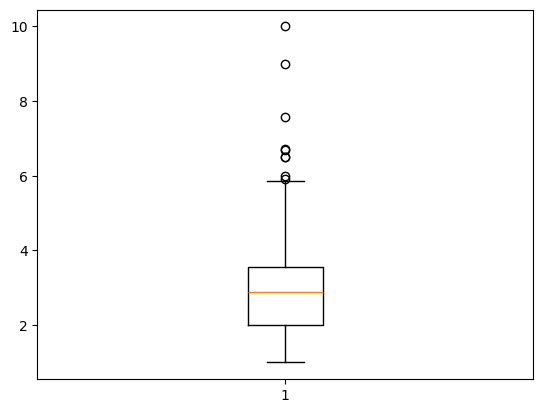

In [3]:
import matplotlib.pyplot as plt

plt.boxplot(x=tips["tip"])
plt.show()

异常数据的处理方式通常是：取数据中的最大值和最小值进行异常值替换

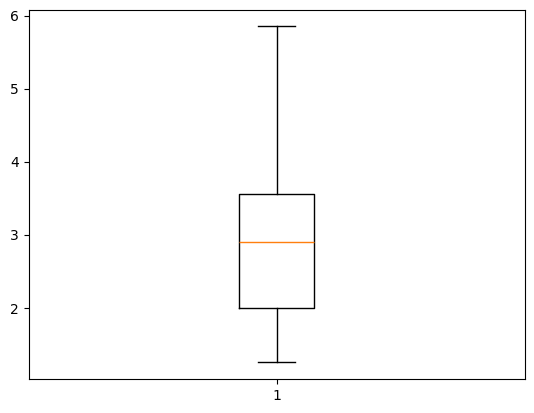

In [4]:
replace_value1 = tips["tip"][tips["tip"] < topnum2].max()
tips.loc[tips["tip"] > topnum2, "tip"] = replace_value1
replace_value2 = tips["tip"][tips["tip"] > bottomnum2].min()
tips.loc[tips["tip"] < bottomnum2, "tip"] = replace_value2
# 可视化异常值
plt.boxplot(x=tips["tip"])
plt.show()

## 小波变化

小波阈值去噪，使用到的库为 `PyWavelets` / `pywt`

maximum level is 4


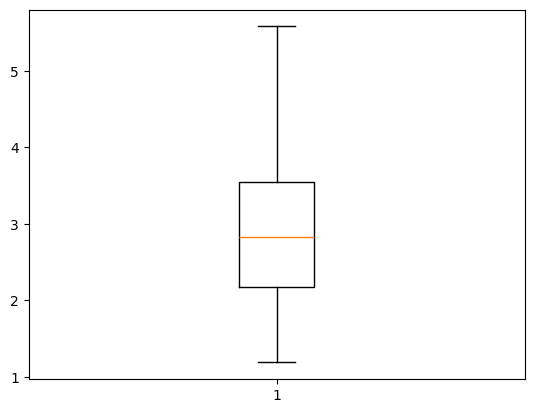

In [5]:
import pywt

ecg = tips["tip"].values


def pywt_wave(ecg):
    index = []
    data = []
    for i in range(len(ecg) - 1):
        X = float(i)
        Y = float(ecg[i])
        index.append(X)
        data.append(Y)
    w = pywt.Wavelet("db8")  # 选用Daubechies8小波
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    print("maximum level is " + str(maxlev))
    threshold = 0.1  # 过滤（阈值）
    coeffs = pywt.wavedec(data, "db8", level=maxlev)  # 将信号进行小波分解
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))  # 将噪声滤波
    datarec = pywt.waverec(coeffs, "db8")  # 将信号进行小波重构
    return datarec


datarec = pywt_wave(ecg)
# 可视化异常值
plt.boxplot(x=datarec)
plt.show()

## PyOD库

`PyOD`一般是专门用于检测多变量数据中的异常值

In [6]:
from pyod.models.knn import KNN  # imprt kNN分类器

data = tips[["tip"]]
# 训练一个kNN检测器
clf_name = "kNN"
clf = KNN()  # 初始化检测器clf
clf.fit(data)  # 使用X_train训练检测器clf
# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
data["labels"] = y_train_pred
data["scores"] = y_train_scores
print(data)

      tip  labels  scores
0    1.25       0    0.00
1    1.66       0    0.05
2    3.50       0    0.00
3    3.31       0    0.08
4    3.61       1    0.10
..    ...     ...     ...
239  5.85       0    0.00
240  2.00       0    0.00
241  2.00       0    0.00
242  1.75       0    0.07
243  3.00       0    0.00

[244 rows x 3 columns]


C:\Users\27360\AppData\Local\Temp\ipykernel_4876\2575896800.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels']  = y_train_pred
C:\Users\27360\AppData\Local\Temp\ipykernel_4876\2575896800.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['scores']  = y_train_scores
